In [26]:
import tensorflow as tf
import numpy as np
import pickle
import tensorflow.keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D , Reshape , ZeroPadding2D,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
with open("RML2016.10a_dict.pkl",'rb') as file:     #打开数据集
    Xd = pickle.load(file, encoding='latin1')       #使用pickle模块打开

snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])  #snrs信噪比  mods 调制方式
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)   #将X堆叠起来(110000, 2, 128)
print(mods)
print(snrs)

['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [28]:
#划分训练集和测试集
np.random.seed(2016)   #种子是为了保证每次生成的随机数一样  也可以换成其他的随机数
n_examples = X.shape[0] #有110000个样本
n_train = n_examples // 2    
train_idx = np.random.choice(range(0, n_examples), size=n_train, replace=False)
test_idx = list(set(range(0, n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [29]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


In [30]:
dr = 0.4 # dropout rate (%)舍弃的比率 可调
model = Sequential()     #sequential方式构建网络
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))    #全零填充
#添加卷积层 256个卷积核 卷积核尺寸为1*3 不使用全零填充 激活函数是relu
model.add(Conv2D(256, 1, 3, padding='valid', activation="relu", name="conv1", kernel_initializer='glorot_uniform',data_format='channels_first'))
#dropout层，舍弃40%的神经元
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Conv2D(80, 2, 3, padding='valid', activation="relu", name="conv2", kernel_initializer='glorot_uniform',data_format='channels_first'))
model.add(Dropout(dr))
#拉直层  把输入特征拉直变成一维数组
model.add(Flatten())
#全连接层   神经元个数256 激活函数为relu
model.add(Dense(256, activation='relu', kernel_initializer='he_normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( len(classes), kernel_initializer='he_normal', name="dense2" ))
#使用softmax分类器
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
#配置神经网络训练方法   损失函数为categorical_accuracy  优化器为adam
model.compile(loss='categorical_crossentropy', optimizer='adam')
#网络总结
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 1, 6, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 2, 43)        512       
_________________________________________________________________
dropout_6 (Dropout)          (None, 256, 2, 43)        0         
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 256, 6, 43)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 80, 2, 14)         82000     
_________________________________________________________________
dropout_7 (Dropout)          (None, 80, 2, 14)        

In [31]:
nb_epoch = 200    # 训练网络的epochs数量
batch_size = 1024  # 每次epoch送入网络的数量

In [32]:
# 训练过程
# 断点续训
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5' #存下网络参数数据
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
   # show_accuracy=False,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        tensorflow.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# 只要训练完成就重新载入最优参数
model.load_weights(filepath)

Epoch 1/200
108/108 - 10s - loss: 2.3327 - val_loss: 2.2407
Epoch 2/200
108/108 - 10s - loss: 2.2221 - val_loss: 2.2000
Epoch 3/200
108/108 - 10s - loss: 2.1689 - val_loss: 2.1163
Epoch 4/200
108/108 - 10s - loss: 2.0985 - val_loss: 2.0390
Epoch 5/200
108/108 - 10s - loss: 2.0428 - val_loss: 1.9892
Epoch 6/200
108/108 - 10s - loss: 2.0107 - val_loss: 1.9607
Epoch 7/200
108/108 - 10s - loss: 1.9866 - val_loss: 1.9350
Epoch 8/200
108/108 - 10s - loss: 1.9642 - val_loss: 1.9035
Epoch 9/200
108/108 - 10s - loss: 1.9481 - val_loss: 1.8849
Epoch 10/200
108/108 - 10s - loss: 1.9348 - val_loss: 1.8706
Epoch 11/200
108/108 - 10s - loss: 1.9210 - val_loss: 1.8587
Epoch 12/200
108/108 - 10s - loss: 1.9131 - val_loss: 1.8495
Epoch 13/200
108/108 - 10s - loss: 1.9063 - val_loss: 1.8424
Epoch 14/200
108/108 - 10s - loss: 1.8971 - val_loss: 1.8291
Epoch 15/200
108/108 - 10s - loss: 1.8953 - val_loss: 1.8293
Epoch 16/200
108/108 - 10s - loss: 1.8869 - val_loss: 1.8148
Epoch 17/200
108/108 - 10s - loss

In [33]:
score = model.evaluate(X_test, Y_test,  verbose=0, batch_size=batch_size)
print (score)

1.6821486949920654


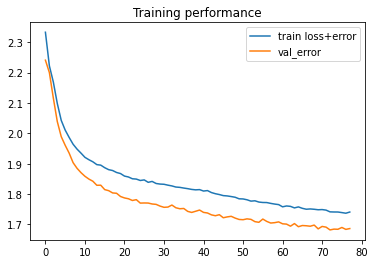

In [34]:
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

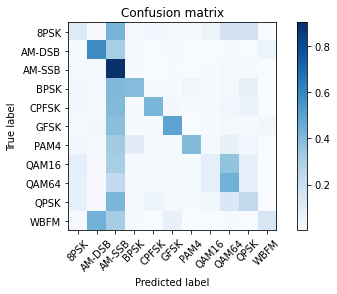

In [35]:
# 预测矩阵
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

SNR:  -20
Overall Accuracy:  0.09533394327538884
SNR:  -18
Overall Accuracy:  0.09264305177111716
SNR:  -16
Overall Accuracy:  0.09243849493487699
SNR:  -14
Overall Accuracy:  0.09220498015156983
SNR:  -12
Overall Accuracy:  0.10665451230628988
SNR:  -10
Overall Accuracy:  0.13133108228185533
SNR:  -8
Overall Accuracy:  0.16130810214954988
SNR:  -6
Overall Accuracy:  0.23643695014662758
SNR:  -4
Overall Accuracy:  0.2968576709796673
SNR:  -2
Overall Accuracy:  0.37808417997097243
SNR:  0
Overall Accuracy:  0.4821167883211679
SNR:  2
Overall Accuracy:  0.5441657579062159
SNR:  4
Overall Accuracy:  0.6002202643171806
SNR:  6
Overall Accuracy:  0.6030685920577618
SNR:  8
Overall Accuracy:  0.6099188458070334
SNR:  10
Overall Accuracy:  0.6196721311475409
SNR:  12
Overall Accuracy:  0.6165127648017382
SNR:  14
Overall Accuracy:  0.6196715261118287
SNR:  16
Overall Accuracy:  0.6070588235294118
SNR:  18
Overall Accuracy:  0.6273627362736274


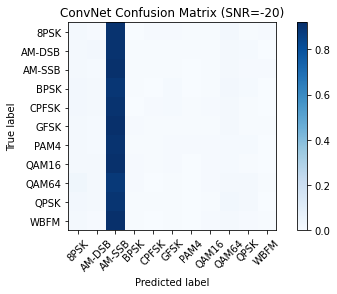

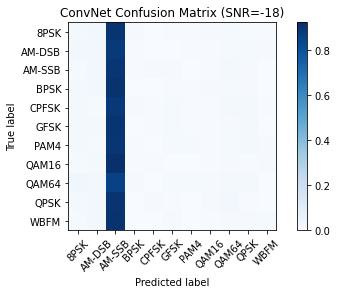

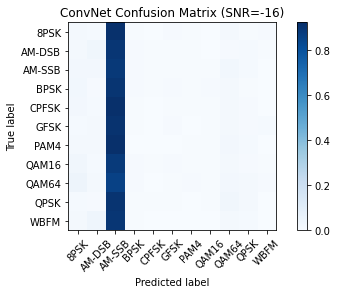

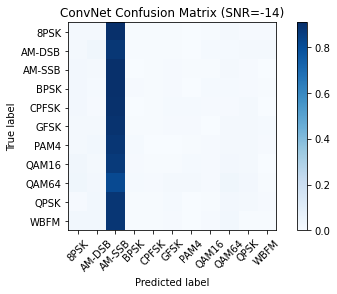

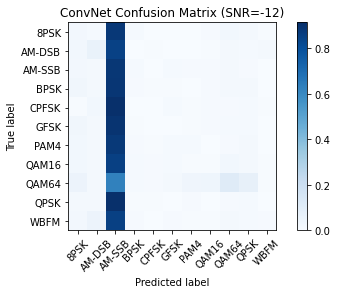

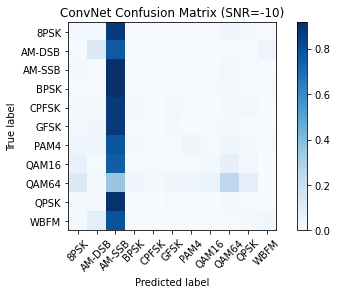

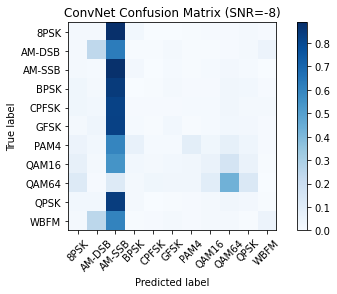

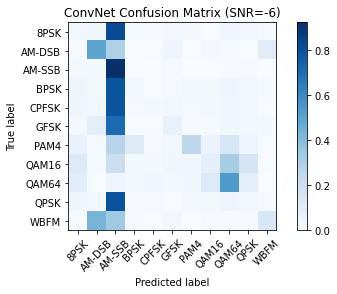

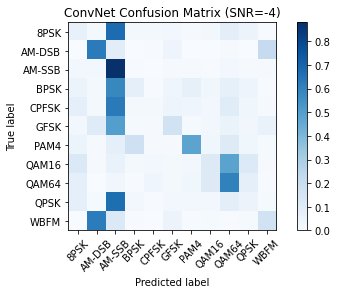

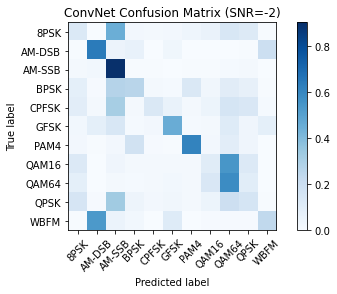

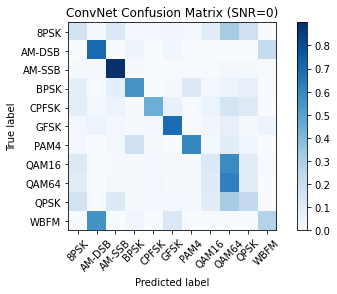

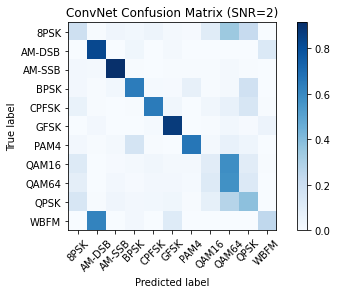

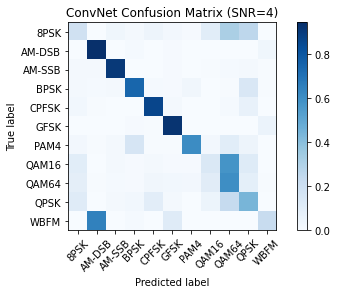

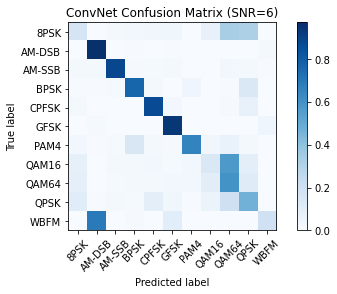

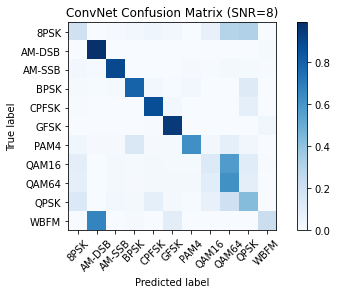

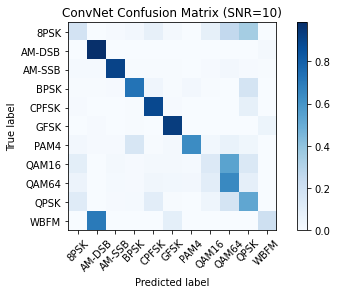

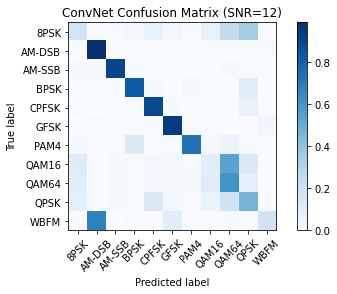

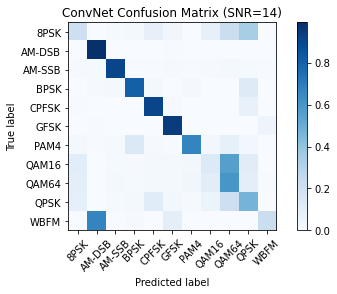

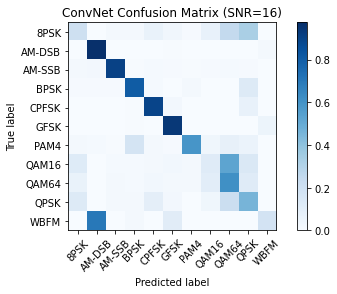

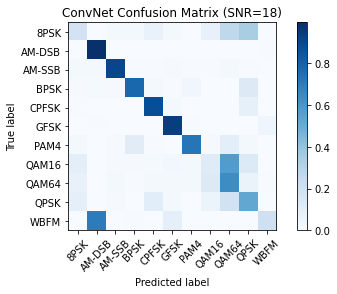

In [36]:
# 不同信噪比情况下的分类效果
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs) == snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs) == snr)]

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])
    for i in range(0, test_X_i.shape[0]):
        j = list(test_Y_i[i, :]).index(1)
        k = int(np.argmax(test_Y_i_hat[i, :]))
        conf[j, k] = conf[j, k] + 1
    for i in range(0, len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])

    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)" % (snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("SNR: ", snr)
    print("Overall Accuracy: ", cor / (cor + ncor))

    acc[snr] = 1.0 * cor / (cor + ncor)

Text(0.5, 1.0, 'CNN Classification Accuracy on dataset RadioML 2016.10 Alpha')

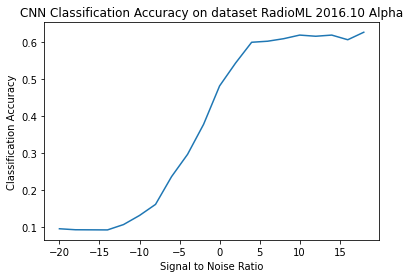

In [38]:
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN Classification Accuracy on dataset RadioML 2016.10 Alpha")